## Libraries

In [2]:
!pip install contractions
!pip install glove-python-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 3.6 MB/s 
     |████████████████████████████████| 287 kB 41.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 8.3 MB/s 


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import torchtext
import contractions
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
import multiprocessing
from gensim.models import Word2Vec
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import Dataset

from pathlib import Path
import shutil
import requests

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
try: 
    from google.colab import drive
    drive.mount('/content/drive')
    project_dir = Path('/content/drive/MyDrive/NLP_project_2/')    
except ModuleNotFoundError: # running on local machine
    project_dir = Path.cwd()

print(f'using project directory: "{project_dir}"')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
using project directory: "/content/drive/MyDrive/NLP_project_2"


# Import Data

In [7]:
source_url= "https://www.statmt.org/europarl/v7/it-en.tgz"
# download tar file
archive_file = torchtext.utils.download_from_url(source_url, root=project_dir/'data')
# unzip archive
torchtext.utils.extract_archive(archive_file)

en_corpus_file = project_dir/'data'/'europarl-v7.it-en.en'
it_corpus_file = project_dir/'data'/'europarl-v7.it-en.it'
assert en_corpus_file.is_file()
assert it_corpus_file.is_file()

# create dir for model checkpoints
checkpoint_dir = project_dir / 'checkpoints'
checkpoint_dir.mkdir(exist_ok=True)

In [8]:
def read_file(file_name, col_name=''):
  with open(file_name, 'r', encoding='utf-8') as f:
    return list(f.readlines())

In [9]:
en_data = pd.Series(read_file(en_corpus_file), name='en')
# en_data = read_file(en_corpus_file).rename('en')
it_data = pd.Series(read_file(it_corpus_file), name='it')

# it_data = read_file(it_corpus_file, 'it')
data = pd.concat([en_data, it_data], axis=1).sample(frac=0.1)
display(data.head())


,en,it
1441645,Nowhere will this policy matter more perhaps t...,Molto probabilmente questa politica sarà più i...
1052053,The situation is even more serious where child...,La situazione è ancora più grave nel caso dei ...
505122,"For several years, we, the Greens, have been f...",Da molti anni noi Verdi ci battiamo per il con...
1649094,"Secondly, our proposal to include funds in the...","Secondo: , il Parlamento europeo deve espressa..."
454265,The President has referred to the European Uni...,Il signor Presidente ha accennato all’intenzio...


# Task 1: Data exploration (10%)
For this task you should extract some insights (i.e., some statistics and graphs) from the provided data.

It could be the length differences between two languages and also the number of sentences in the
whole corpus. Don’t limit yourself into these examples and try to find more insights in the data. Please
highlight some of the most important findings in your report.

Moreover, since the dataset is too large, randomly select 10% of data (data sampling) to train your
models on in the next steps.

Hint: if you faced codec errors in reading files, the “codecs” library could be used.

Insights:
- length in chars or in words (one or the other?)
- length difference
- number of sentences
- vocabulary size
- words common in both languages?

## Length in chars

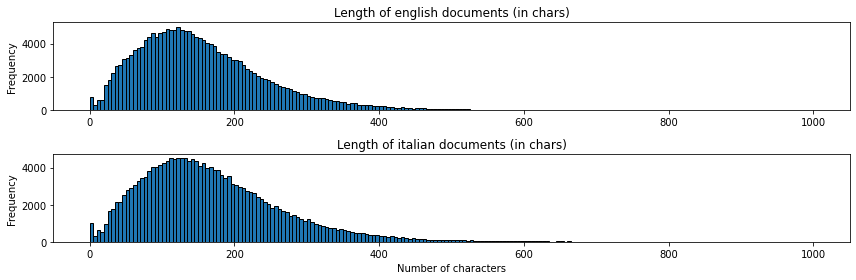

In [10]:
fig, axes = plt.subplots(2, figsize=(12,4))
data['en'].str.len().plot(kind='hist', bins=200, range=[0, 1000], ax=axes[0], title='Length of english documents (in chars)', edgecolor='black')
data['it'].str.len().plot(kind='hist', bins=200, range=[0, 1000], ax=axes[1], title='Length of italian documents (in chars)', edgecolor='black')
plt.xlabel("Number of characters")
fig.tight_layout()
plt.show()

## Length in words

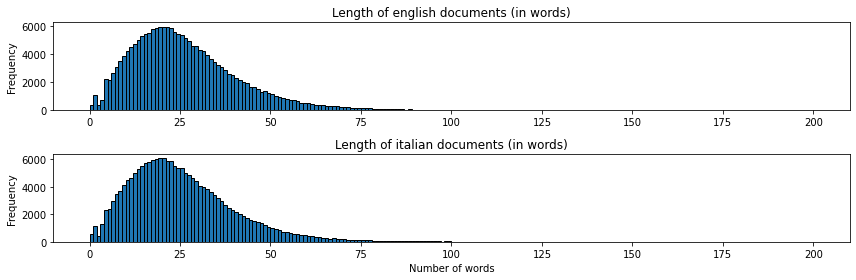

In [11]:
fig, axes = plt.subplots(2, figsize=(12,4))
data['en'].str.split().map(lambda x:len(x)).plot(kind='hist', bins=200, range=[0, 200], ax=axes[0], title='Length of english documents (in words)', edgecolor='black')
data['it'].str.split().map(lambda x:len(x)).plot(kind='hist', bins=200, range=[0, 200], ax=axes[1], title='Length of italian documents (in words)', edgecolor='black')
plt.xlabel("Number of words")
fig.tight_layout()
plt.show()

## Length difference

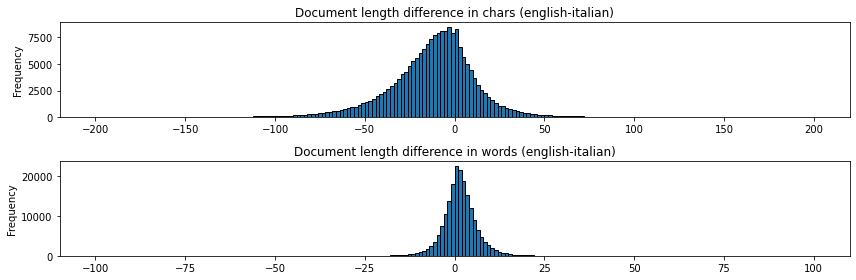

In [12]:
fig, axes = plt.subplots(2, figsize=(12,4))
(data['en'].str.len()-data['it'].str.len()).plot(kind='hist', bins=200, range=[-200, 200], ax=axes[0], title='Document length difference in chars (english-italian)', edgecolor='black')
(data['en'].str.split().map(lambda x:len(x))-data['it'].str.split().map(lambda x:len(x))).plot(kind='hist', bins=200, range=[-100, 100], ax=axes[1], title='Document length difference in words (english-italian)', edgecolor='black')
fig.tight_layout()
plt.show()

## Number of sentences

In [13]:
# split each cell into sentences 
tokenized_data_en = data['en'].map(lambda s: sent_tokenize(s, language='english')).copy()
tokenized_data_it = data['it'].map(lambda s: sent_tokenize(s, language='italian')).copy()
nb_en_sentences = tokenized_data_en.map(lambda l: len(l)).sum()
nb_it_sentences = tokenized_data_it.map(lambda l: len(l)).sum()

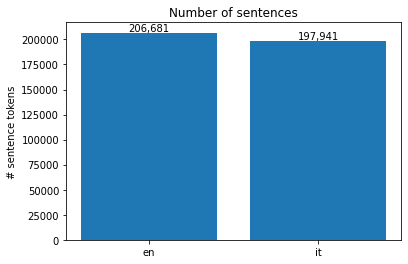

In [14]:
labels = ['en', 'it']
values = [nb_en_sentences, nb_it_sentences]

# Plot the figure.
fig, ax = plt.subplots()
plt.bar(labels, values)
ax.set_title("Number of sentences")
ax.set_ylabel("# sentence tokens")
ax.set_xticklabels(labels)

rects = ax.patches

for rect, value in zip(rects, values):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, f'{value:,}', ha="center", va="bottom"
    )

plt.show()

## Vocabulary size

In [15]:
def wordCount(data):
  word_counter = Counter()
  tokenized_data = data.map(lambda s: word_tokenize(s.lower())).copy()
  tokenized_data.apply(word_counter.update)
  return word_counter

en_vocab = set(wordCount(data['en']).keys())
it_vocab = set(wordCount(data['it']).keys())

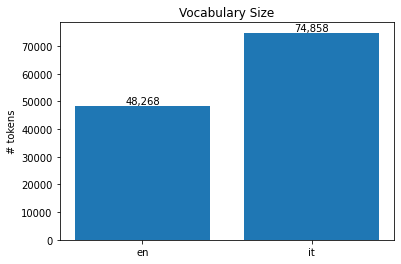

In [16]:
labels = ['en', 'it']
values = [len(en_vocab), len(it_vocab)]

# Plot the figure.
fig, ax = plt.subplots()
plt.bar(labels, values)
ax.set_title("Vocabulary Size")
ax.set_ylabel("# tokens")
ax.set_xticklabels(labels)

rects = ax.patches

for rect, value in zip(rects, values):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, f'{value:,}', ha="center", va="bottom"
    )

plt.show()

# Task 2: Pre-processing (15%)
In this task, first, apply all the necessary pre-processing steps that you think they would help to better prepare your data for the next steps. You don’t have to apply all the pre-processing tasks which are
covered in the course. Regarding the report, you should briefly mention it in your report that why you
decided to apply the chosen pre-processing steps (and why not the others).

Among all the pre-processing tasks, the following are recommended:

- lowercase the text

- strip empty lines and their correspondences

- remove lines with XML-Tags (starting with "<")

=> note: there are no lines starting with "<", but there are lines containing: >some words= , is this what is meant here?

our ideas:
- seperate punctuation/special characters from words (Hello! --> Hello !) => word_tokenize does this actually
- undo compact forms (ex: I'm --> I am)
- remove special characters < and =
- many sentences contain the legal report number ex: (A5-0052/1999) -> remove substrings of format: '\([A-Z][0-9]-[0-9]{4}\/[0-9]{4}\)'
- many sentences start with for ex: - (SV) or . (PT) -> remove substrings of format: '- \([A-Z][A-Z]\)' and '. \([A-Z][A-Z]\)'
- any pre processing specific to Italian?

In [17]:
#   special_chars = ['>', '=']
#   text = text.translate({ord(c): " " for c in special_chars})   # remove special characters

In [18]:
def prep(text :str) -> str:
    # remove legals
    text = re.sub(pattern=r'\([A-Z][0-9]-[0-9]{4}\/[0-9]{2,4}\)', repl='', string=text)
    # remove country codes
    text = re.sub(pattern=r'(. )?\([A-Z]{2}\)', repl='', string=text)
    # remove XML tags
    text = re.sub(pattern=r'<.*?>', repl='', string=text)
    # remove sentence if it contains no letter
    text = re.sub(pattern=r'^[^a-zA-Z]*$', repl='', string=text)
    # lower case
    text = text.lower()
    # undo contractions
    text = contractions.fix(text)
    return text

def tokenize(text, language):
    langMap = {
        'en': 'english',
        'it': 'italian',
        'sw': 'swedish',
    }
    if language in langMap:
        language = langMap[language]
    token = word_tokenize(text, language=language)
    return token

def preprocess(data):
    prep_data = data.copy()
    # preprocess
    prep_data['en'] = prep_data['en'].map(lambda t: prep(t))
    prep_data['it'] = prep_data['it'].map(lambda t: prep(t))
    # tokenize
    prep_data['en'] = prep_data['en'].map(lambda t: tokenize(t, language='en'))
    prep_data['it'] = prep_data['it'].map(lambda t: tokenize(t, language='it'))
    # remove empty tokens
    prep_data = prep_data.replace([], np.nan).dropna() 
    return prep_data

In [19]:
en_it_df = preprocess(data)
en_sent_list = en_it_df['en'].tolist()
it_sent_list = en_it_df['it'].tolist()

# append "start of sentence" and "end of sentence" tokens so that the embedding algorithms learn an embedding for these tokens
en_sent_list.append(['<SOS>'])
en_sent_list.append(['<EOS>'])
it_sent_list.append(['<SOS>'])
it_sent_list.append(['<EOS>'])

In [20]:
print(en_sent_list[0])
print(it_sent_list[0])

['nowhere', 'will', 'this', 'policy', 'matter', 'more', 'perhaps', 'than', 'in', 'tunisia', '.']
['molto', 'probabilmente', 'questa', 'politica', 'sarà', 'più', 'incisiva', 'in', 'tunisia', 'che', 'altrove', '.']


# Task 3: Neural Machine Translation (45%)
In this task you should do the following sub-tasks. Choose two evaluation metrics and report your
results using these two metrics.

- Split data into train, validation and test sets. Use 20% of data as the test set.

- Develop an RNN based sequence to sequence model (encoder-decoder) to translate English
input into Italian text.

  - In your report describe your reasons for choosing the architecture that you are using
for the task

  - Track the impact of different embedding models (e.g., Glove, Word2Vec and …) on
the performance of your model.

  - Interpret the results of your model in the report. Does the length of text impact on
the performance of the model? What characteristic of sentences led to better
translation by the model?

- Change your input and target languages (Translate from Italian to English) and train your mode again. Compare the results in this step with the results from the previous step where English
was the input language.

- Develop a character-based model that train to translate characters into the target language. Compare the results by this model with the achieved results from the word-based models before.

Please report all the achieved results with either models in your report document. Moreover, describe
the hyper-parameters of your neural network model in the report.

In [21]:
# 1. build vocab


In [69]:
from torchtext.vocab import build_vocab_from_iterator, vocab
from collections import Counter, OrderedDict

def build_vocab(sentences, specials, min_freq):
    
    tokens = [word 
              for sent in sentences 
              for word in sent]
    counter = Counter(tokens)
    frequency_ranking = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    v = vocab(OrderedDict(frequency_ranking), min_freq=min_freq, specials=specials)
    return v

vocab_en = build_vocab(en_sent_list, specials=['<EOS>', '<SOS>', "<unk>"], min_freq=1)
vocab_it = build_vocab(it_sent_list, specials=['<EOS>', '<SOS>', "<unk>"], min_freq=1)
# vocab_en.set_default_index(-1) # set <unk> as default 

len(vocab_en), len(vocab_it)

(47750, 74332)

In [23]:
# floatTensorWithWeights.size = (num_embeddings, embedding_dim)



In [24]:
# full_ds = Europarl(en_it_df.en, en_it_df.it)

# fractions = [0.7, 0.1, 0.2]
# set_sizes = subset_sizes(len(full_ds), fractions)

# train_ds, val_ds, test_ds = torch.utils.data.random_split(full_ds, lengths=set_sizes)

# BATCH_SIZE = 32

# trainLoader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
# testLoader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)
# valLoader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)



In [25]:
# class EncoderNew(nn.Module):
#     def __init__(self, input_size,embedding_size, hidden_size, num_layers=1, dropout_rate=0.5):
#         super(EncoderNew, self).__init__()
#         self.input_size = input_size
#         self.embedding_size = embedding_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers

#         self.dropout = nn.Dropout(dropout_rate)   
#         self.embedding = nn.Embedding(input_size, embedding_size) 
#         self.rnn = nn.LSTM(
#             input_size=embedding_size, 
#             hidden_size=hidden_size, 
#             num_layers=num_layers,
#             dropout=0, 
#             batch_first=True
#         )

#     def forward(self, x, device):
#         embedding = self.dropout(self.embedding(x))
#         outs, (hidden, cell) = self.rnn(embedding)

#         # h = self.initHidden(x.size()[0])
#         return hidden, cell
#         _, h_n = self.rnn(x, h)
#         return h_n

#     def initHidden(self, batch_size):
#         return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)



## Embeddings

- CharNgrams
- Glove
- Word2Vec
  - with CBOW
  - with skip-gram

  (FastText, Context2Vec, CoVe ELMo)

In [26]:
# num_emb = 1000
# emb_dim = 100
# emb = nn.Embedding(num_emb, emb_dim)
# emb.weight.requires_grad = False

# embedding_weights = np.zeros((num_emb, emb_dim))
# emb.weight = nn.Parameter(torch.FloatTensor(embedding_weights))


### Glove


## Hyperparameters for embedding

In [142]:
emb_min_count = 2
emb_window = 7
emb_epochs = 5
emb_threads = multiprocessing.cpu_count() - 1
emb_dim = 32

In [141]:
from torchtext.vocab import build_vocab_from_iterator, vocab
from collections import Counter, OrderedDict

def build_vocab(sentences, specials, min_freq):
    
    tokens = [word 
              for sent in sentences 
              for word in sent]
    counter = Counter(tokens)
    frequency_ranking = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    v = vocab(OrderedDict(frequency_ranking), min_freq=min_freq, specials=specials)
    return v

vocab_en = build_vocab(en_sent_list, specials=['<EOS>', '<SOS>'], min_freq=1)
vocab_it = build_vocab(it_sent_list, specials=['<EOS>', '<SOS>'], min_freq=1)
# vocab_en.set_default_index(-1) # set <unk> as default 

len(vocab_en), len(vocab_it)

(47749, 74331)

In [143]:
from glove import Glove, Corpus

def glove_embedding(sent_corpus, vocab_dict=None): # can use vocab_en.get_stoi() vocab dict
    glove_corpus = Corpus(vocab_dict) 
    glove_corpus.fit(sent_corpus, window=emb_window)  # build co-occurrence matrix
    model = Glove(no_components=emb_dim)
    model.fit(glove_corpus.matrix, epochs=emb_epochs, no_threads=emb_threads, verbose=True)
    model.add_dictionary(glove_corpus.dictionary)
    weights = torch.FloatTensor(model.word_vectors)
    return nn.Embedding.from_pretrained(weights)  # init embedding layer with trained weights


In [ ]:
from gensim.models.callbacks import CallbackAny2Vec

class w2v_logger(CallbackAny2Vec):
    '''print loss after each epoch.'''
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f'\r epoch {self.epoch}')
        self.epoch += 1

def word2vec_embedding(sent_corpus, vocab_dict, use_skipgram):
    model = Word2Vec(min_count=emb_min_count, 
                     window=emb_window, 
                     size=emb_dim, 
                     sg=1 if use_skipgram else 0, 
                     workers=emb_threads)
    # init vocab
    model.build_vocab_from_freq(vocab_dict)
    # train word2vec
    model.train(en_sent_list, total_examples=len(sent_corpus), epochs=emb_epochs, callbacks=[w2v_logger()])
    weights = torch.FloatTensor(model.wv.vectors)
    return nn.Embedding.from_pretrained(weights)


def skipgram_embedding(sent_corpus, vocab_dict):
    return word2vec_embedding(sent_corpus, vocab_dict, use_skipgram=True)

def cbow_embedding(sent_corpus, vocab_dict):
    return word2vec_embedding(sent_corpus, vocab_dict, use_skipgram=False)

## Train Glove embeddings

In [145]:
force_train = True
glove_file_en = checkpoint_dir/'embedding.glove.en'
glove_file_it = checkpoint_dir/'embedding.glove.it'


# make en embeddding
if not force_train and glove_file_en.is_file():
    emb_glove_en = torch.load(glove_file_en)
else:
    emb_glove_en = glove_embedding(en_sent_list, vocab_en.get_stoi())
    torch.save(emb_glove_en, glove_file_en)


# make it embeddding
if not force_train and glove_file_it.is_file():
    emb_glove_it = torch.load(glove_file_it)
else:
    emb_glove_it = glove_embedding(it_sent_list, vocab_it.get_stoi())
    torch.save(emb_glove_it, glove_file_it)

# emb_glove_en(torch.tensor(vocab_en["euro"]))

Performing 5 training epochs with 1 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Performing 5 training epochs with 1 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [156]:
def make_embedding(name, sentences, vocab, lang, force_train=False):
    # either load embedding from disk or train from scratch
    
    name=name.lower()
    # vocab = build_vocab(sentences, specials=['<SOS>', '<EOS>'], min_freq=1)
    emb_funcs = {
        'glove': glove_embedding, 
        'skipgram': skipgram_embedding, 
        'cbow': cbow_embedding,
    }
    if name not in emb_funcs:
        raise KeyError('invalid embedding name')

    checkpoint_file = checkpoint_dir / f'embedding.{name}.{lang}'
    if not force_train and checkpoint_file.is_file():
        embedding = torch.load(checkpoint_file)
    else: 
        embedding = emb_funcs[name](sentences, vocab.get_stoi())
        torch.save(embedding, checkpoint_file)
    return embedding


In [ ]:
force_train = False

In [161]:
emb_glove_en = make_embedding('glove', en_sent_list, vocab_en, 'en', force_train=force_train)
emb_glove_it = make_embedding('glove', it_sent_list, vocab_it, 'it', force_train=force_train)
print(emb_glove_en, emb_glove_it)

Performing 5 training epochs with 1 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Performing 5 training epochs with 1 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Embedding(47749, 32) Embedding(74331, 32)


In [ ]:
emb_sg_en = make_embedding('skipgram', en_sent_list, vocab_en, 'en', force_train=force_train)
emb_sg_it = make_embedding('skipgram', it_sent_list, vocab_it, 'it', force_train=force_train)
print(emb_sg_en, emb_sg_it)

 epoch 1
 epoch 2
 epoch 3
 epoch 4
 epoch 5
 epoch 1
 epoch 2
 epoch 3


In [ ]:
emb_cbow_en = make_embedding('cbow', en_sent_list, vocab_en, 'en', force_train=force_train)
emb_cbow_it = make_embedding('cbow', it_sent_list, vocab_it, 'it', force_train=force_train)
print(emb_cbow_en, emb_cbow_it)

In [127]:
emb_sg_en = skipgram_embedding(en_sent_list, vocab_en.get_stoi())
emb_sg_en(torch.tensor(vocab_en["euro"]))

tensor([ 0.0081,  0.1129, -0.0336, -0.0153, -0.0104, -0.0042, -0.0174, -0.1075,
        -0.0919, -0.2061,  0.1077,  0.0890,  0.0924, -0.0607,  0.0922, -0.1499,
        -0.1073, -0.1084,  0.0197,  0.2289,  0.0698, -0.1245,  0.0523, -0.1232,
         0.0721,  0.0333,  0.0252, -0.0450,  0.2108,  0.0898, -0.1152, -0.1276])

In [27]:
VECTOR_SIZE = 32

cores = multiprocessing.cpu_count()


(Embedding(47749, 32), Embedding(47748, 32))

### Word2Vec (skip-gram)

In [28]:
# Training english word2vec (skip-gram) model
w2v_sg_en_model = Word2Vec(min_count=1, 
                           window=2, 
                           size=VECTOR_SIZE, 
                           sg=1, 
                           workers=cores-1)
w2v_sg_en_model.build_vocab(en_sent_list)
print("Training Word2Vec (Skip-gram) model for English corpus...")
w2v_sg_en_model.train(en_sent_list, total_examples=w2v_sg_en_model.corpus_count, epochs=10)

print("Done.")
# Save model
w2v_sg_en_model.save(str(checkpoint_dir/"w2v_sg_en_model"))

Training Word2Vec (Skip-gram) model for English corpus...
Done.


In [29]:
# Training italian word2vec (skip-gram) model
w2v_sg_it_model = Word2Vec(min_count=1, 
                           window=2, 
                           size=VECTOR_SIZE, 
                           sg=1, 
                           workers=cores-1)
w2v_sg_it_model.build_vocab(it_sent_list)
print("Training Word2Vec (Skip-gram) model for Italian corpus...")
w2v_sg_it_model.train(it_sent_list, total_examples=w2v_sg_it_model.corpus_count, epochs=10)
print("Done.")

# Save model
w2v_sg_it_model.save(str(checkpoint_dir/"w2v_sg_it_model"))

Training Word2Vec (Skip-gram) model for Italian corpus...
Done.


### Word2Vec (CBOW)

In [30]:
# Training english word2vec (CBOW) model
w2v_cbow_en_model = Word2Vec(min_count=1, 
                           window=2, 
                           size=VECTOR_SIZE, 
                           sg=0, 
                           workers=cores-1)
w2v_cbow_en_model.build_vocab(en_sent_list)
print("Training Word2Vec (CBOW) model for English corpus...")
w2v_cbow_en_model.train(en_sent_list, total_examples=w2v_sg_en_model.corpus_count, epochs=10)
print("Done.")

# Training italian word2vec (CBOW) model
w2v_cbow_it_model = Word2Vec(min_count=1, 
                           window=2, 
                           size=VECTOR_SIZE, 
                           sg=0, 
                           workers=cores-1)
w2v_cbow_it_model.build_vocab(it_sent_list)
print("Training Word2Vec (CBOW) model for Italian corpus...")
w2v_cbow_it_model.train(it_sent_list, total_examples=w2v_sg_it_model.corpus_count, epochs=10)
print("Done.")

# Save models
w2v_cbow_en_model.save(str(checkpoint_dir/"w2v_cbow_en_model"))
w2v_cbow_it_model.save(str(checkpoint_dir/"w2v_cbow_it_model"))

Training Word2Vec (CBOW) model for English corpus...
Done.
Training Word2Vec (CBOW) model for Italian corpus...
Done.


### Glove

In [31]:
# from torchtext.vocab import CharNGram, GloVe

# tokenizers: spacy, moses, toktok, subword
# torchtext.data.utils.get_tokenizer(tokenizer='spacy', language='en_core_web_sm')


### Character embedding

In [ ]:
# TODO: embedding for character-based model

In [ ]:
sample = en_sent_list[0]
vocab_en[sample]

## Dataset Class


In [ ]:
class Europarl(Dataset):
    def __init__(self, corpus_a, corpus_b: pd.Series):
        self.lang_a = corpus_a.name 
        self.lang_b = corpus_b.name
        
        self.corpus_a = corpus_a.to_list()
        self.corpus_b = corpus_b.to_list()
        
    def __len__(self):
        if len(self.corpus_a) != len(self.corpus_b):
            raise ValueError('Number of documents in language A is different to language B.')
        else:
            return len(self.corpus_a)

    def __getitem__(self, idx):
        self.corpus_a[idx].append('<EOS>')
        self.corpus_b[idx].append('<EOS>')
        return (self.corpus_a[idx], self.corpus_b[idx])


def subset_sizes(full_len, fractions):
    head = fractions[0]
    tail = fractions[1:]
    sizes = [int(len(full_ds) * s) for s in tail]
    return [full_len - sum(sizes)] + sizes


In [ ]:
def get_collate_func(embedding_a, vocab_a, embedding_b, vocab_b):
    
    def collate(batch):
        emb_a = emb_b = []
        for sent_a, sent_b in batch:
            




### Collate Functions

In [ ]:
# collate_fn for Word2Vec SKIP-GRAM dataloader
def w2v_sg_en_it_collate(batch):
  modelA = Word2Vec.load(str(checkpoint_dir/"w2v_sg_en_model"))
  modelB = Word2Vec.load(str(checkpoint_dir/"w2v_sg_it_model"))
  return batch_embed(batch, modelA, modelB)

# collate_fn for Word2Vec CBOW dataloader
def w2v_cbow_en_it_collate(batch):
  modelA = Word2Vec.load(str(checkpoint_dir/"w2v_cbow_en_model"))
  modelB = Word2Vec.load(str(checkpoint_dir/"w2v_cbow_it_model"))
  return batch_embed(batch, modelA, modelB)

def batch_embed(batch, modelA, modelB):
  lang_A_embeddings, lang_B_embeddings = [], []
  for (lang_A_sentence, lang_B_sentence) in batch:
    lang_A_embeddings.append(torch.FloatTensor(sent_embed(lang_A_sentence, modelA)))
    lang_B_embeddings.append(torch.FloatTensor(sent_embed(lang_B_sentence, modelB)))
  return pad_sequence(lang_A_embeddings, batch_first=True), pad_sequence(lang_B_embeddings, batch_first=True)

def sent_embed(sentence, model):
  embedding = []
  for w in sentence:
    embedding.append(model.wv[w])
  return embedding

# TODO collate function for glove embedding

## Model

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=1):
    super(Encoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

  def forward(self, x, device):
    h = self.initHidden(x.size()[0])
    _, h_n = self.rnn(x, h)
    return h_n

  def initHidden(self, batch_size):
    return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

class Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(Decoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x, h, target):
    batch_size = target.size()[0]
    sent_length = target.size()[1]
    outputs = torch.zeros(sent_length, batch_size, self.output_size).to(device)
    for t in range(target.size()[1]):
      o, h = self.rnn(x, h)
      x = self.linear(o)
      outputs[t] = x.view(1, batch_size, -1)
    
    return outputs.view(batch_size, sent_length, self.output_size)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

### Train Function

In [ ]:
def predict(input, target, encoder, decoder, sos_token):
  batch_size = input.size()[0]
        
  # encode batch
  encoder_h = encoder(input, device)
  
  # prepare decoder inputs       
  decoder_in = sos_token.repeat(batch_size, 1).view(batch_size, 1, -1).to(device)
  decoder_h = encoder_h

  #decoder batch
  decoder_o = decoder(decoder_in, decoder_h, target)

  return decoder_o

In [ ]:
def train(train_dl, val_dl, encoder, decoder, encoder_opt, decoder_opt, criterion, sos_token, epochs=10):
  for e in range(epochs):
    print("Epoch: ", e)
    acc_loss = 0
    last_val_loss = 1e5 # big number

    # train
    for b, train_data in enumerate(train_dl):
      # set gradients to zero
      encoder_opt.zero_grad()
      decoder_opt.zero_grad()

      # input and target language
      lang_A, lang_B = train_data[0].to(device), train_data[1].to(device)

      # predict
      output = predict(input=lang_A, target=lang_B, encoder=encoder, decoder=decoder, sos_token=sos_token)
  
      # compute and print loss
      loss = criterion(output, lang_B)
      acc_loss += loss
      avg_loss = acc_loss/(b+1)
      if b%100==0 and b>0:
        print(f'--> Average loss after {b} batches: {avg_loss}')
      
      # backpropagation
      loss.backward()
      encoder_opt.step()
      decoder_opt.step()

    # validation
    last_val_loss = 1e5 # just a big number
    acc_val_loss = 0
    with torch.no_grad():
      for b, val_data in enumerate(val_dl):
        # input and target language
        lang_A, lang_B = val_data[0].to(device), val_data[1].to(device)

        # predict
        output = predict(input=lang_A, target=lang_B, encoder=encoder, decoder=decoder, sos_token=sos_token)
    
        # compute loss
        val_loss = criterion(output, lang_B)
        acc_val_loss += val_loss
        avg_val_loss = acc_val_loss/(b+1)
      
      # if avg val loss better than last epoch, save model
      if avg_val_loss < last_val_loss:
        last_val_loss = val_loss
        torch.save(encoder.state_dict(), checkpoint_dir/'encoder.dict')
        torch.save(decoder.state_dict(), checkpoint_dir/'decoder.dict')

      print(f'End of epoch {e} ---- loss:{avg_loss} ---- val_loss:{avg_val_loss}')


In [ ]:
def get_device():
    if torch.has_cuda:
        return torch.device('cuda')
    if torch.has_mps: 
        return torch.device('mps')
    return torch.device('cpu')

device = get_device()
print(f"using {device} backend")

using cuda backend


## Split data

In [ ]:
full_ds = Europarl(en_it_df.en, en_it_df.it)

fractions = [0.7, 0.1, 0.2]
set_sizes = subset_sizes(len(full_ds), fractions)

train_ds, val_ds, test_ds = torch.utils.data.random_split(full_ds, lengths=set_sizes)

## English to Italian translation

### with Word2Vec Skip-gram embedding

In [ ]:
BATCH_SIZE = 128
trainLoader_sg = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=w2v_sg_en_it_collate, shuffle=True)
testLoader_sg = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=w2v_sg_en_it_collate, shuffle=True)
valLoader_sg = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=w2v_sg_en_it_collate, shuffle=True)

In [ ]:
# Hyper Parameters
input_size = VECTOR_SIZE
target_size = VECTOR_SIZE
hidden_size = 512

# Model set-up
encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(input_size, hidden_size, target_size).to(device)

encoder_opt = optim.Adam(encoder.parameters())
decoder_opt = optim.Adam(decoder.parameters())

criterion = nn.MSELoss()

w2v_sg_it_model = Word2Vec.load(str(checkpoint_dir/"w2v_sg_it_model"))
sos_token = torch.FloatTensor(w2v_sg_it_model.wv['<SOS>'])

# Train
# train(trainLoader_sg, 
#       valLoader_sg, 
#       encoder, 
#       decoder, 
#       encoder_opt, 
#       decoder_opt, 
#       criterion,
#       sos_token)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  app.launch_new_instance()


### with Word2Vec CBOW embedding

In [ ]:
# TODO

### with Glove embedding

## Evaluation

In [ ]:
encoder.load_state_dict(torch.load('encoder.dict'))
decoder.load_state_dict(torch.load('decoder.dict'))

FileNotFoundError: ignored

In [ ]:
from torchmetrics.functional import bleu_score
preds = ['the cat is on the mat']
target = [['there is a cat on the mat', 'a cat is on the mat']]
bleu_score(preds, target)

ModuleNotFoundError: ignored

# Task 4: Neural Machine Translation with Attention (30%)
In this task, improve your models from the last step by using the attention mechanism in your model. Compare the achieved results with and without attention mechanism in your report. Also visualize the attention weights for a sample instance and highlight it in your report.

## Attention Model

In [ ]:
class AttEncoder(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers=1):
    super(AttEncoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

  def forward(self, x, device):
    h_0 = self.initHidden(x.size()[0])
    o, h = self.rnn(x, h_0)
    return o, h

  def initHidden(self, batch_size):
    return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

class AttDecoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1):
    super(AttDecoder, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x, h_0, target, encoder_o):
    batch_size = target.size()[0]
    sent_length = target.size()[1]
    outputs = torch.zeros(sent_length, batch_size, self.output_size).to(device)
    h = h_0
    for t in range(target.size()[1]):
      # attention score as dot-product
      att_scores = torch.bmm(
          h.view(batch_size, 1, hidden_size), 
          encoder_o.view(batch_size, hidden_size, -1)
          ) # att_scores size: batch_size x 1 x (sequ_length of encoder input)
      att_weights = nn.functional.softmax(att_scores) 
      att_output = torch.bmm(att_weights, encoder_o) # att_output size: batch_size x 1 x hidden_size
      
      o, h = self.rnn(x, att_output.view(1, batch_size, -1))
      x = self.linear(o)
      outputs[t] = x.view(1, batch_size, -1)
    
    return outputs.view(batch_size, sent_length, self.output_size), att_weights

In [ ]:
def attPredict(input, target, encoder, decoder, sos_token):
  batch_size = input.size()[0]
        
  # encode batch
  encoder_o, encoder_h = encoder(input, device)
  
  # prepare decoder inputs       
  decoder_in = sos_token.repeat(batch_size, 1).view(batch_size, 1, -1).to(device)
  decoder_h = encoder_h

  #decoder batch
  decoder_o = decoder(decoder_in, decoder_h, target, encoder_o)

  return decoder_o

In [ ]:
def attTrain(train_dl, val_dl, encoder, decoder, encoder_opt, decoder_opt, criterion, sos_token, epochs=10):
  for e in range(epochs):
    print("Epoch: ", e)
    acc_loss = 0
    last_val_loss = 1e5 # big number

    # train
    for b, train_data in enumerate(train_dl):
      # set gradients to zero
      encoder_opt.zero_grad()
      decoder_opt.zero_grad()

      # input and target language
      lang_A, lang_B = train_data[0].to(device), train_data[1].to(device)

      # predict
      output, _ = attPredict(input=lang_A, target=lang_B, encoder=encoder, decoder=decoder, sos_token=sos_token)
  
      # compute and print loss
      loss = criterion(output, lang_B)
      acc_loss += loss
      avg_loss = acc_loss/(b+1)
      if b%100==0 and b>0:
        print(f'--> Average loss after {b} batches: {avg_loss}')
      
      # backpropagation
      loss.backward()
      encoder_opt.step()
      decoder_opt.step()

    # validation
    last_val_loss = 1e5 # just a big number
    acc_val_loss = 0
    with torch.no_grad():
      for b, val_data in enumerate(val_dl):
        # input and target language
        lang_A, lang_B = val_data[0].to(device), val_data[1].to(device)

        # predict
        output = predict(input=lang_A, target=lang_B, encoder=encoder, decoder=decoder, sos_token=sos_token)
    
        # compute loss
        val_loss = criterion(output, lang_B)
        acc_val_loss += val_loss
        avg_val_loss = acc_val_loss/(b+1)
      
      # if avg val loss better than last epoch, save model
      if avg_val_loss < last_val_loss:
        last_val_loss = val_loss
        torch.save(encoder.state_dict(), checkpoint_dir/'encoder.dict')
        torch.save(decoder.state_dict(), checkpoint_dir/'decoder.dict')

      print(f'End of epoch {e} ---- loss:{avg_loss} ---- val_loss:{avg_val_loss}')


In [ ]:
# Hyper Parameters
input_size = VECTOR_SIZE
target_size = VECTOR_SIZE
hidden_size = 512

# Model set-up
encoder = AttEncoder(input_size, hidden_size).to(device)
decoder = AttDecoder(input_size, hidden_size, target_size).to(device)

encoder_opt = optim.Adam(encoder.parameters())
decoder_opt = optim.Adam(decoder.parameters())

criterion = nn.MSELoss()

w2v_sg_it_model = Word2Vec.load(str(checkpoint_dir/"w2v_sg_it_model"))
sos_token = torch.FloatTensor(w2v_sg_it_model.wv['<SOS>'])

# Train
attTrain(trainLoader_sg, 
      valLoader_sg, 
      encoder, 
      decoder, 
      encoder_opt, 
      decoder_opt, 
      criterion,
      sos_token)

Epoch:  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  app.launch_new_instance()


RuntimeError: ignored

# Bonus Task: Pivot Translation (+30%)
A pivot language, sometimes also called a bridge language, is an artificial or natural language used as an intermediary language for translation between many different languages – to translate between any pair of languages A and B, one translates A to the pivot language P, then from P to B. For this task, you should develop a neural machine translation model for translating Italian to Swedish, using English as the pivot language. You can download the Swedish-English parallel corpus from here.